In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Список конфігурацій
configurations = [
    {"max_features": 15000, "maxlen": 250, "name": "BiLSTM", "type": "BiLSTM"},
    {"max_features": 15000, "maxlen": 250, "name": "GRU", "type": "GRU"},
    {"max_features": 5000, "maxlen": 100, "name": "Small", "type": "LSTM"},
    {"max_features": 10000, "maxlen": 200, "name": "Medium", "type": "LSTM"},
    {"max_features": 20000, "maxlen": 300, "name": "Large", "type": "LSTM"},
]

results = {}

# Список Моделей
def create_model(config):
    model = Sequential()
    model.add(Embedding(config['max_features'], 32, input_length=config['maxlen']))

    if config['type'] == 'LSTM':
        model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    elif config['type'] == 'BiLSTM':
        model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
        model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
    elif config['type'] == 'GRU':
        model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
for config in configurations:
    print(f"\nTraining model {config['name']} ({config['type']}):")
    print(f"max_features: {config['max_features']}, maxlen: {config['maxlen']}")

    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=config['max_features'])
    x_train = pad_sequences(x_train, maxlen=config['maxlen'])
    x_test = pad_sequences(x_test, maxlen=config['maxlen'])

    model = create_model(config)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    results[config['name']] = {
        'history': history.history,
        'test_accuracy': test_accuracy,
        'config': config,
        'model': model
    }


Training model BiLSTM (BiLSTM):
max_features: 15000, maxlen: 250
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 714ms/step - accuracy: 0.6253 - loss: 0.6299 - val_accuracy: 0.8042 - val_loss: 0.4237
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 266s 727ms/step - accuracy: 0.8559 - loss: 0.3587 - val_accuracy: 0.8366 - val_loss: 0.3781
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 258s 717ms/step - accuracy: 0.8884 - loss: 0.2934 - val_accuracy: 0.8066 - val_loss: 0.4223
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 257s 702ms/step - accuracy: 0.8908 - loss: 0.2790 - val_accuracy: 0.8170 - val_loss: 0.4331
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 222s 710ms/step - accuracy: 0.9100 - loss: 0.2489 - val_accuracy: 0.8482 - val_loss: 0.3937
782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - accuracy: 0.8414 - loss: 0.4049
Test accuracy: 84.57%

Training model GRU (GRU):
max_features: 15000, maxlen: 250
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 244ms/step - accuracy: 0.5821 - loss: 27348015513600.0000 - val_accuracy: 0.

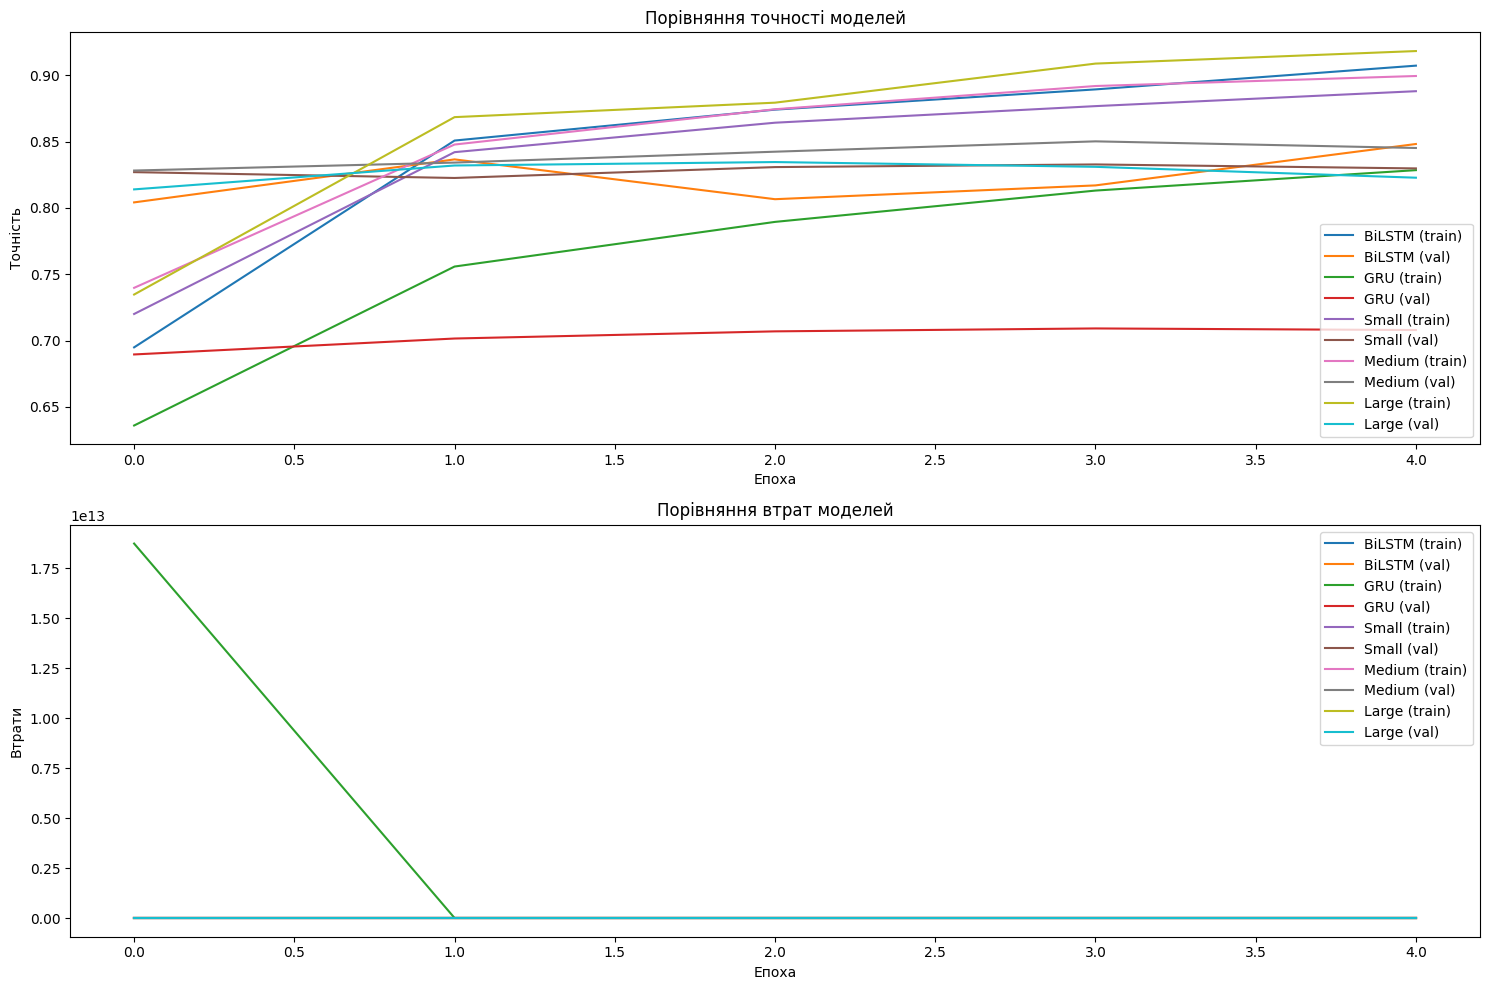

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
for name, result in results.items():
    plt.plot(result['history']['accuracy'], label=f'{name} (train)')
    plt.plot(result['history']['val_accuracy'], label=f'{name} (val)')
plt.title('Порівняння точності моделей')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

plt.subplot(2, 1, 2)
for name, result in results.items():
    plt.plot(result['history']['loss'], label=f'{name} (train)')
    plt.plot(result['history']['val_loss'], label=f'{name} (val)')
plt.title('Порівняння втрат моделей')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def predict_sentiment(text, model, config):
    word_index = imdb.get_word_index()
    word_index = {k:(v+3) for k,v in word_index.items()}
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2
    word_index["<UNUSED>"] = 3

    def text_to_sequence(text):
        return [word_index.get(word.lower(), word_index["<UNK>"]) for word in text.split()]

    sequence = text_to_sequence(text)
    data = pad_sequences([sequence], maxlen=config['maxlen'])
    prediction = model.predict(data)[0][0]
    return "Позитивний" if prediction > 0.5 else "Негативний", prediction

test_reviews = [
    "This movie was amazing and incredibly well-made",
    "Worst film I've ever seen, absolutely terrible",
    "An okay movie with some good moments"
]

print("\nПорівняння передбачень:")
print("-" * 100)
print(f"{'Рецензія':<50} {'Модель':<10} {'Сентимент':<12} {'Впевненість':<10}")
print("-" * 100)

for review in test_reviews:
    for config in configurations:
        model = results[config['name']]['model']
        sentiment, confidence = predict_sentiment(review, model, config)
        print(f"{review[:47]+'...':<50} {config['name']:<10} {sentiment:<12} {confidence:.2%}")
    print("-" * 100)

print("\nПорівняльна таблиця результатів:")
print("-" * 90)
print(f"{'Модель':<10} {'Тип':<8} {'max_features':<12} {'maxlen':<8} {'Точність тесту':<15}")
print("-" * 90)
for name, result in results.items():
    print(f"{name:<10} {result['config']['type']:<8} {result['config']['max_features']:<12} {result['config']['maxlen']:<8} {result['test_accuracy']*100:.2f}%")


Порівняння передбачень:
----------------------------------------------------------------------------------------------------
Рецензія                                           Модель     Сентимент    Впевненість
----------------------------------------------------------------------------------------------------
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
This movie was amazing and incredibly well-made... BiLSTM     Негативний   2.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
This movie was amazing and incredibly well-made... GRU        Позитивний   67.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
This movie was amazing and incredibly well-made... Small      Позитивний   64.72%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
This movie was amazing and incredibly well-made... Medium     Позитивний   91.53%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
This movie was amazing and incredibly well-made... Large      Позитивний   98.30%
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Worst film I've ever seen, absolutely terrible...  BiLSTM     Негативний   1.47%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Worst film I've ever seen, absolutely terrible...  GRU        Негативний   1.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Worst film I've ever seen, absolutely terrible...  Small      Негативний   0.81%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Worst film I've ever seen, absolutely terrible...  Medium     Негативний   1.53%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Worst film I've ever seen, absolutely terrible...  Large      Негативний   7.35%
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
An okay movie with some good moments...    